#LSTM Neural Network model for stock market prediction

Optional installing of missing libraries

In [1]:
# install libraries missing from Google Colab Notebook
# !pip install yfinance
# !pip install minisom
# !pip install pyfolio

# Reading in the libraries

In [2]:
# import libraries
import random # module 'random' has no attribute '__version__'
import tensorflow as tf # verison 2.4.0
import yfinance as yf # version 0.1.54
import pandas as pd # version 1.1.5
import seaborn as sns # version 0.11.1
import matplotlib.pyplot as plt # version 3.2.2
from sklearn.preprocessing import MinMaxScaler # version 0.22.2.post1
from tensorflow.keras.models import Sequential # verison 2.4.0
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout # verison 2.4.0
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator  # verison 2.4.0
from tensorflow.keras.callbacks import EarlyStopping # verison 2.4.0
from sklearn.metrics import mean_squared_error # version 0.22.2.post1
import numpy as np # verison 1.19.5
from sklearn.metrics import classification_report, confusion_matrix # version 0.22.2.post1
from tensorflow.keras.optimizers import SGD # verison 2.4.0
from minisom import MiniSom # module 'minisom' has no attribute '__version__'
from sklearn.cluster import KMeans # version 0.22.2.post1
from sklearn.tree import DecisionTreeRegressor # version 0.22.2.post1
from sklearn.ensemble import AdaBoostRegressor # version 0.22.2.post1
import math # module 'math' has no attribute '__version__'
from sklearn import tree # version 0.22.2.post1
import graphviz # version 0.10.1
import pyfolio as pf # version 0.9.2
import pdb # module 'pdb' has no attribute '__version__'
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


Choose the stock

In [3]:
# choose the stock
#stock = 'DIS' 
#stock = 'MELI'
stock = 'TDOC'

if stock == 'DIS':
  start_date = '2000-01-01'
  end_date = '2021-01-01'
  test_length = 765 # days
if stock == 'MELI':
  start_date = '2007-09-01'
  end_date = '2021-01-01'
  test_length = 510 # days
if stock == 'TDOC':
  start_date = '2015-01-01'
  end_date = '2021-01-01'
  test_length = 300 # days

User defined variables for the neural network model

In [4]:
# set the user defined variables for the neural network model
length = 30 # six weeks - sequence length
num_days_to_predict = 1 # number of days for each target
show_feature_importance = True # True of False
SOM = True # True of False
k_means = True # True or False
metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')] # None, ['accuracy'], [tf.keras.metrics.AUC(name='AUC')], ['accuracy', tf.keras.metrics.AUC(name='AUC')] 
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=40) # reduce overfitting (monitor='val_loss', mode='min', patience=x) or (monitor='AUC', mode='max', patience=x)

## Features

Function to read in the data

In [5]:
# read in the data
def read_in_data(stock, start_date, end_date):
    return yf.download(stock, start=start_date, end=end_date)

Function to create the heatmap plot

In [6]:
# creating heatmap plot
def plot_heatmap(df):
    corrmat = df.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(15, 15))
    #plot heat map
    sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, fmt="0.2f", linewidths=0.5, square=False, cbar=True, cmap='RdYlGn')

Function to create plots for features over the time range

In [7]:
# creating plots for each feature over the time range
def feature_over_time_range(df, stock):
    values = df.values
    # specify columns to plot
    num_col = len(df.columns)
    groups = range(num_col)
    i = 1
    # plot each column
    plt.figure(figsize=(15,8))
    plt.suptitle('Subplots showing the value of each feature over the time range for %s' % stock)
    for group in groups:
      plt.subplot(len(groups), 1, i)
      plt.plot(values[:, group])
      plt.title(df.columns[group], y=0.5, loc='right')
      i += 1
    plt.show()

Function to create the Self Organising Map of the features

In [8]:
# self organising map function
def create_SOM_of_features(df, stock):
    # feature reduction
    corrmat_df = df.corr()

    # scale the correlation matrix and convert to numpy array
    scaler = MinMaxScaler()
    corrmat_numpy_array = scaler.fit_transform(corrmat_df)

    # Initialize a 30 x 30 SOM
    som = MiniSom(30, 30, corrmat_numpy_array.shape[0], learning_rate=0.5, sigma=5, random_seed=42)

    # Initialize with randon weights
    som.random_weights_init(corrmat_numpy_array)

    # Trains SOM with 100 iterations
    som.train_batch(corrmat_numpy_array, 100, verbose=True)

    # Plot SOM
    plt.figure(figsize=(20, 20))
    for ix in range(len(corrmat_numpy_array)):
        winner = som.winner(corrmat_numpy_array[ix])
        plt.text(winner[0], winner[1], corrmat_df.index[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
    plt.imshow(som.distance_map())
    plt.grid(False)
    plt.title('Self Organizing Map for %s' % stock)
    plt.show()

    # because the feature labels are on top of each other
    # we will assign each a unique number to each feature and plot that on the map instead
    corrmat_df['number'] = range(0, len(corrmat_df))

    # Plot SOM
    plt.figure(figsize=(20, 20))
    for ix in range(len(corrmat_numpy_array)):
        winner = som.winner(corrmat_numpy_array[ix])
        plt.text(winner[0], winner[1], corrmat_df.number[ix], bbox=dict(facecolor='white', alpha=0.5, lw=0)) 
    plt.imshow(som.distance_map())
    plt.grid(False)
    plt.title('Self Organizing Map for %s' % stock)
    plt.show()

    return corrmat_df

Functions to perform k-mean clustering on the features

In [9]:
# reducing number of features
def first_run_of_k_means(df, stock):
    # create a correlation matrix
    corrmat_df = df.corr()

    # setting the model parameters
    init = 'random'
    n_init = 10
    max_iter = 100
    random_state = 42

    # now to perform the elbow test to see how many clusters I need
    Ks = range(1, 25)
    km = [KMeans(n_clusters = n, init = init, n_init = n_init, max_iter = max_iter, random_state = random_state) for n in Ks]
    distorsions = [km[i].fit(df).inertia_ for i in range(len(km))]

    fig = plt.figure(figsize=(15, 5))
    plt.plot(Ks, distorsions)
    plt.grid(True)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia Attribute')
    plt.title('Elbow curve for %s' % stock)
    plt.show()

    return corrmat_df

In [10]:
def second_run_of_k_means(df, n_clusters):
    # building the second k-means model
    # setting the model parameters
    init = 'random'
    n_init = 10
    max_iter = 100
    random_state = 42
    
    kmeans = KMeans(n_clusters = n_clusters, init = init, n_init = n_init, max_iter = max_iter, random_state = random_state)

    # training the model
    kmeans.fit(df)

    # number of cluster each training dataset is assigned to
    labels = kmeans.labels_ 

    # add labels as another column to corrmat_df
    df['cluster_no'] = labels
    df['cluster_no'].head()

    # loop through each cluster and print the features assigned to it
    for cluster_no in np.unique(df['cluster_no']):
      temp_df = df.loc[df['cluster_no'] == cluster_no]
      print('\nFeatures assigned to cluster: ', cluster_no)
      print(temp_df.index)

Function to create the lagged columns for the column passed to the function

In [11]:
# function to create lagged columns for the column passed to the function
def add_lags(df, column, lags):
    cols = [column]
    new_columns = []
    for lag in range(1, lags+1):
        col = '%s_lag_%d' % (column, lag)
        df[col] = df[column].shift(lag)
        cols.append(col)
        new_columns.append(col)
    return df, cols, new_columns

Function to create future lags for the target column

In [12]:
# function to create future lags for target column - future lags
def add_future_output_for_train(df, column, lags):
    cols = [column]
    new_columns = []
    for lag in range(1, lags+1):
        col = '%s_+%d' % (column, lag)
        df[col] = df[column].shift(-lag)
        cols.append(col)
        new_columns.append(col)
    return df, cols, new_columns

Function to split the test and train dataset, given the dataframe passed to it, and the test length

In [13]:
# split test and train
def split_test_and_train(df, test_len, verbose=None):
  test_index = len(df) - test_len
  train_df = df.iloc[: test_index]
  test_df = df.iloc[test_index:]

  if verbose != None: 
    print('Lenght of training dataset: ', len(train_df))
    print('\nTraining dataset head')
    print(train_df.head())
    print('\nTraining dataset tail')
    print(train_df.tail())
    print('\nLength of test dataset: ', len(test_df))
    print('\nTest dataset head')
    print(test_df.head())
    print('\nTest dataset tail')
    print(test_df.tail())

  return train_df, test_df

Fucntion to split the features and target column/s into two separate dataset for both the train and test dataframes

In [14]:
# split features and target column
def split_features_and_target(train_df, test_df, target_column, columns_drop=None):
  # extract the target column values
  y_train = train_df[target_column].values
  y_test = test_df[target_column].values

  if columns_drop == None:
      x_train = train_df
      x_test = test_df
  else:
    # drop the new columns from the train and test dataframes
    x_train = train_df.drop(columns = columns_drop)
    x_test = test_df.drop(columns = columns_drop)

  return x_train, y_train, x_test, y_test

Function to plot feature importance using either a simple regression decision tree, or simple AdaBoost model

In [15]:
def feature_importance(df, model, stock):
  test_length = 10
  target_col =  'return'
  columns_drop = ['return']  

  # delete rows with nan in them
  df = df.dropna(axis=0) 

  # normalise the data
  normalised_df=(df-df.mean())/df.std()
      
  # first split test and train
  train_df, test_df = split_test_and_train(normalised_df, test_length, verbose=None)
  # next separate features and target column
  x_train, y_train, x_test, y_test = split_features_and_target(train_df, test_df, target_col, columns_drop=columns_drop)
  
  if len(y_train.shape) > 1:
      # just grab the first column
      y_train = y_train[:, 1]
  # convert y_test and y_trian to pandas series 
  y_train = pd.DataFrame(data = y_train, columns = ['returns'])  
  y_test = pd.DataFrame(data = y_test, columns = ['returns']) 
  # set index the same as features 
  y_train = y_train.set_index(x_train.index)
  y_test = y_test.set_index(x_test.index)

  # needed to plot the decision tree
  data_col_names = x_train.columns.values

  if model == 'adaboost':
      n_estimators = 100
      learning_rate = 0.2
      base_estimator = DecisionTreeRegressor(max_depth=1)

      simple_model = AdaBoostRegressor(n_estimators=n_estimators, learning_rate=learning_rate, base_estimator=base_estimator, random_state=42)
      # train the model
      simple_model.fit(x_train, y_train)
      # run the test set through the model
      predicted_array = simple_model.predict(x_test)
  else:
      # parameters for the model
      criterion = 'mse'
      max_depth = 5
      min_samples_leaf = 5

      simple_model = DecisionTreeRegressor(criterion = criterion,
                                      max_depth = max_depth, 
                                      min_samples_leaf = min_samples_leaf, 
                                      random_state = 0)

      simple_model.fit(x_train, y_train)
      predicted_array = simple_model.predict(x_test) 

  # convert predicted_array into pandas dataframe
  predicted_array = pd.DataFrame(data = predicted_array, columns=['Returns']) 
  # set index the same as features 
  predicted_array = predicted_array.set_index(y_test.index)

  # plot up feature importance 
  features = x_train.columns
  importance = simple_model.feature_importances_

  y_test = y_test.reset_index(drop=True)
  predicted_array = predicted_array.reset_index(drop=True)

  true_and_pred_data = {'true_value': y_test['returns'], 'predicted_value': predicted_array['Returns']}
  predicted_true_testset = pd.DataFrame(data = true_and_pred_data, columns = ['true_value', 'predicted_value'])
  indices = np.argsort(importance)

  plt.figure(figsize=(15, 7))
  plt.title('Feature importance for %s' % stock)
  plt.barh(range(len(indices)), importance[indices], color='b', align='center')
  plt.yticks(range(len(indices)), features[indices])
  plt.xlabel('Relative Importance')
  plt.show()

  # plot up the decision tree
  fn = data_col_names
  cn = np.unique(y_train.apply(str))
  # DOT data
  dot_data = tree.export_graphviz(simple_model, out_file=None, 
                                  feature_names=fn,  
                                  class_names=cn,
                                  filled=True)

  # Draw graph
  graph = graphviz.Source(dot_data, format="png") 
  graph


Feature to take the stock data read in from yfinance and create all features and lagged features

In [16]:
# feature engineering
def data_preparation(master_df, stock, show_feature_importance=False, start_date=False, end_date=False, model=False):  
    # make a copy of the dataframe
    df = master_df.copy() 

    # date index as column
    # ordering by date - in case date column is in the wrong order
    df['date_time'] =  pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df.sort_values('date_time', axis=0)
    # finally drop the date_time column
    df = df.drop(['date_time'], axis = 1)
    
    # create the MACD line, signal line and MACD signal line
    day12 = df['Adj Close'].ewm(span=12).mean()  
    day26 = df['Adj Close'].ewm(span=26).mean()
    macd = [] 
    counter=0  
    while counter < (len(day12)):
        macd.append(day12.iloc[counter] - day26.iloc[counter]) 
        counter += 1
    df['macd'] = macd
    df['signal'] = df['macd'].ewm(span=9).mean() 
    df['temp'] = (df['macd'] - df['signal'])
    df['macd_signal'] = 1
    df.loc[df['temp']<0, ['macd_signal']] = 0
    df = df.drop(['macd', 'signal', 'temp'], axis=1)

    # Simple moving average
    sma_time = 5
    df['SMA_5_day'] = df['Adj Close'].rolling(sma_time, win_type=None).mean()
    sma_time = 10
    df['SMA_10_day'] = df['Adj Close'].rolling(sma_time, win_type=None).mean()
    sma_time = 20
    df['SMA_20_day'] = df['Adj Close'].rolling(sma_time, win_type=None).mean()
    sma_time = 50
    df['SMA_50_day'] = df['Adj Close'].rolling(sma_time, win_type=None).mean()
    sma_time = 200
    df['SMA_200_day'] = df['Adj Close'].rolling(sma_time, win_type=None).mean()

    # Momentum
    momentum_time = 1
    df['momentum_1_day'] = df['Adj Close'] - df['Adj Close'].shift(momentum_time)
    momentum_time = 5
    df['momentum_5_day'] = df['Adj Close'] - df['Adj Close'].shift(momentum_time)
    momentum_time = 20
    df['momentum_20_day'] = df['Adj Close'] - df['Adj Close'].shift(momentum_time)
    momentum_time = 30
    df['momentum_30_day'] = df['Adj Close'] - df['Adj Close'].shift(momentum_time)
    momentum_time = 50
    df['momentum_50_day'] = df['Adj Close'] - df['Adj Close'].shift(momentum_time)
    
    # Exponential moving average
    ema_time = 5
    df['EMA_5_day'] = df['Adj Close'].ewm(span=ema_time).mean() 
    ema_time = 10
    df['EMA_10_day'] = df['Adj Close'].ewm(span=ema_time).mean()
    ema_time = 20
    df['EMA_20_day'] = df['Adj Close'].ewm(span=ema_time).mean()
    ema_time = 50
    df['EMA_50_day'] = df['Adj Close'].ewm(span=ema_time).mean()
    ema_time = 200
    df['EMA_200_day'] = df['Adj Close'].ewm(span=ema_time).mean()

    # Open minus Close t-1
    df['open_minus_pre_close'] = df['Open'] - df['Adj Close'].shift(1)

    # One day change in volume
    df['volume_1_day_change'] = df['Volume'] - df['Volume'].shift(1)
    # Two day change in volume
    df['volume_2_day_change'] = df['Volume'] - df['Volume'].shift(2)
    # Three day change in volume
    df['volume_3_day_change'] = df['Volume'] - df['Volume'].shift(3)
    # Four day change in volume
    df['volume_4_day_change'] = df['Volume'] - df['Volume'].shift(4)
    # Five day change in volume
    df['volume_5_day_change'] = df['Volume'] - df['Volume'].shift(5)
    # Twenty day change in volume
    df['volume_20_day_change'] = df['Volume'] - df['Volume'].shift(20)
    # 100 day change in volume
    df['volume_100_day_change'] = df['Volume'] - df['Volume'].shift(100)

    # RSI
    df['up'] = 0
    df['down'] = 0
    df.loc[(df['Adj Close'] - df['Adj Close'].shift(1)) > 0, ['up']] = (df['Adj Close'] - df['Adj Close'].shift(1))
    df.loc[(df['Adj Close'] - df['Adj Close'].shift(1)) < 0, ['down']] = (df['Adj Close'] - df['Adj Close'].shift(1))
  
    df['avg_gain'] = 0
    df['avg_loss'] = 0

    df['avg_gain'] = (df['up'] + df['up'].shift(1) + df['up'].shift(2) + df['up'].shift(3) + df['up'].shift(4) + df['up'].shift(5) + df['up'].shift(6) + df['up'].shift(7) + df['up'].shift(8) + df['up'].shift(9) + df['up'].shift(10) + df['up'].shift(11) + df['up'].shift(12) + df['up'].shift(13))/14.0
    df['avg_loss'] =abs(df['down'] + df['down'].shift(1) + df['down'].shift(2) + df['down'].shift(3) + df['down'].shift(4) + df['down'].shift(5) + df['down'].shift(6) + df['down'].shift(7) + df['down'].shift(8) + df['down'].shift(9) + df['down'].shift(10) + df['down'].shift(11) + df['down'].shift(12) + df['down'].shift(13))/14.0

    df['RSvalue'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RSvalue']))
    df = df.drop(['up', 'down', 'avg_gain', 'avg_loss', 'RSvalue'], axis=1)

    # create Average True Range function
    # rolling average
    n = 20
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['H-L', 'H-PC', 'L-PC', 'TR'],axis=1) # drop columns

    # create vix feature
    vix_df = read_in_data('^VIX', start_date, end_date)
    # add vix_df['Adj Close'] as a feature to df
    df['VIX_Close'] = vix_df['Adj Close']
    # next create the lagged columns
    lag = 5
    df, target_cols, new_cols = add_lags(df, 'VIX_Close', lag)
    # VIX_Close minus 20 days
    df['VIX_Close_lag_20'] = df['VIX_Close'].shift(20)
    # VIX_Close minus 50 days
    df['VIX_Close_lag_50'] = df['VIX_Close'].shift(50)
    # VIX_Close minus 200 days
    df['VIX_Close_lag_200'] = df['VIX_Close'].shift(200)

    # create the return column
    df['return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

    # delete columns not needed
    df = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], axis=1)

    # before adding the lags, let's have a look at the features
    temp_df = df[['macd_signal', 'SMA_5_day', 'momentum_1_day', 'EMA_5_day', 'open_minus_pre_close', 'volume_1_day_change', 'RSI', 'ATR', 'VIX_Close', 'return']]
    #get correlations of each features in dataset
    plot_heatmap(temp_df)
    # plotting features over the time range
    feature_over_time_range(temp_df, stock)

    # plotting feature importance
    if show_feature_importance:
      feature_importance(df, model, stock)

    # create a set of 5 day lags for all columns
    lag = 5
    df, target_cols, new_cols = add_lags(df, 'macd_signal', lag)
    df, target_cols, new_cols = add_lags(df, 'SMA_5_day', lag)
    df, target_cols, new_cols = add_lags(df, 'SMA_10_day', lag)
    df, target_cols, new_cols = add_lags(df, 'momentum_1_day', lag)
    df, target_cols, new_cols = add_lags(df, 'momentum_5_day', lag)
    df, target_cols, new_cols = add_lags(df, 'EMA_5_day', lag)
    df, target_cols, new_cols = add_lags(df, 'EMA_10_day', lag)
    df, target_cols, new_cols = add_lags(df, 'open_minus_pre_close', lag)
    df, target_cols, new_cols = add_lags(df, 'volume_1_day_change', lag)
    df, target_cols, new_cols = add_lags(df, 'volume_2_day_change', lag)
    df, target_cols, new_cols = add_lags(df, 'volume_3_day_change', lag)
    df, target_cols, new_cols = add_lags(df, 'volume_4_day_change', lag)
    df, target_cols, new_cols = add_lags(df, 'volume_5_day_change', lag)
    df, target_cols, new_cols = add_lags(df, 'RSI', lag)
    df, target_cols, new_cols = add_lags(df, 'ATR', lag)
    df, target_cols, new_cols = add_lags(df, 'return', lag)

    # we also want the 10, 15, 20,25 and 30 day lags for the returns
    # returns minus 10 days
    df['return_lag_10'] = df['return'].shift(10)
    # returns minus 15 days
    df['return_lag_15'] = df['return'].shift(15)
    # returns minus 20 days
    df['return_lag_20'] = df['return'].shift(20)
    # returns minus 25 days
    df['return_lag_25'] = df['return'].shift(25)
    # returns minus 30 days
    df['return_lag_30'] = df['return'].shift(30)
    
    # the target is the sign of the return
    df['return_sign'] = np.sign(df['return'].values)
    
    # delete rows with nan in them
    df = df.dropna(axis=0)

    # drop all rows with zero in return_sign column
    df = df[df.return_sign != 0]
    # the assignment says we can class the target value of '1' as '0' and '-1' and '1'
    df['return_sign'] = df['return_sign'].replace(1, 0)
    df['return_sign'] = df['return_sign'].replace(-1, 1)
    
    # percentage of positive and negative returns
    class_value, counts = np.unique(df['return_sign'], return_counts=True)
    print('The percentage of class value: %.0f is %.2f%%' % (class_value[0], (counts[0] / len(df)) * 100.0))
    print('And the percentage of class value: %.0f is %.2f%%' % (class_value[1], (counts[1] / len(df)) * 100.0))
    print('\n')

    return df

Function to scale the features in both the test and the train datasets, using the features in the train dataset passed to it

In [17]:
# scale the features
def scale_features(x_train, x_test):
  # create an instance
  scaler = MinMaxScaler()
  # fitting the data
  scaler.fit(x_train)
  # transform the training data
  scaled_x_train = scaler.transform(x_train)
  # transform the test data
  scaled_x_test = scaler.transform(x_test)

  return scaled_x_train, scaled_x_test

Function to compile the LSTM neural network model

In [18]:
def create_rnn_model(num_neurons_layer_1, num_neurons_layer_2, activation_layer_1, activation_layer_2, input_shape, loss, optimizer, num_layers = 2, layer_type = None, dropout = None, metrics=None):
  # build the model
  model = Sequential ()

  if num_layers == 3:
    if layer_type == 'LSTM':
      # first layer
      model.add(LSTM(num_neurons_layer_1, activation=activation_layer_1, input_shape=input_shape, return_sequences=True)) 
      if dropout != None:
        # droppout layer
        model.add(Dropout(0.5))
      # second layer
      model.add(LSTM(num_neurons_layer_1, activation=activation_layer_1)) 
      if dropout != None:
        # droppout layer
        model.add(Dropout(0.5))
    elif layer_type == 'Dense':
      # first layer
      model.add(LSTM(num_neurons_layer_1, activation=activation_layer_1, input_shape=input_shape)) 
      if dropout != None:
        # droppout layer
        model.add(Dropout(0.5))
      # second layer
      model.add(Dense(math.ceil(num_neurons_layer_1/2.0), activation=activation_layer_1)) 
      if dropout != None:
        # droppout layer
        model.add(Dropout(0.5))
    else:
      print("Please enter 'LSTM' or 'Dense' for layer_type")
  elif num_layers == 5:
      model.add(LSTM(num_neurons_layer_1, activation=activation_layer_1, input_shape=input_shape, return_sequences=True)) 
      model.add(LSTM(num_neurons_layer_1, activation=activation_layer_1, input_shape=input_shape, return_sequences=True)) 
      model.add(LSTM(num_neurons_layer_1, activation=activation_layer_1, input_shape=input_shape, return_sequences=True)) 
      model.add(LSTM(num_neurons_layer_1, activation=activation_layer_1)) 
  else:
    # first layer
    model.add(LSTM(num_neurons_layer_1, activation=activation_layer_1, input_shape=input_shape)) 
    if dropout != None:
      # droppout layer
      model.add(Dropout(0.5)) # reduce overfitting

  # final layer
  model.add(Dense(num_neurons_layer_2, activation=activation_layer_2))
  # compile the model
  if metrics:
      model.compile(loss = loss, optimizer = optimizer, metrics=metrics)
  else:
      model.compile(loss = loss, optimizer = optimizer)
  #model.compile(loss = loss, optimizer = SGD(lr=1))
  
  return model

Function to plot the confusion matrix of the true and predicted datasets passed to it

In [19]:
# confusion matrix
def plot_confusion_matrix(y_true, predicted_array, class_names, title):
    cm = confusion_matrix(y_true, predicted_array)
    print(cm)
    dataframe = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(dataframe, annot=True, cmap='Blues', fmt='g')
    plt.title(title)
    plt.ylabel('True Class'), plt.xlabel('Predicted Class')
    plt.show()
    return cm

Function to set the random seeds for random, numpy and tensorflow

In [20]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

#Reading in the data

In [21]:
print('Read in stock')
master_df = read_in_data(stock, start_date, end_date)
master_df.head()

Read in stock
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-06-30,19.000000,19.000000,19.00,19.000000,19.000000,0
2015-07-01,29.900000,31.900000,27.82,28.500000,28.500000,10512900
2015-07-02,28.090000,29.250000,26.16,28.000000,28.000000,1199200
2015-07-06,26.110001,27.809999,26.01,26.690001,26.690001,512800
2015-07-07,26.930000,27.850000,25.66,27.010000,27.010000,700700


In [22]:
len(master_df)

1388

In [23]:
# checking index data type
type(master_df.index[0])

pandas._libs.tslibs.timestamps.Timestamp

In [24]:
# check for NaNs
master_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

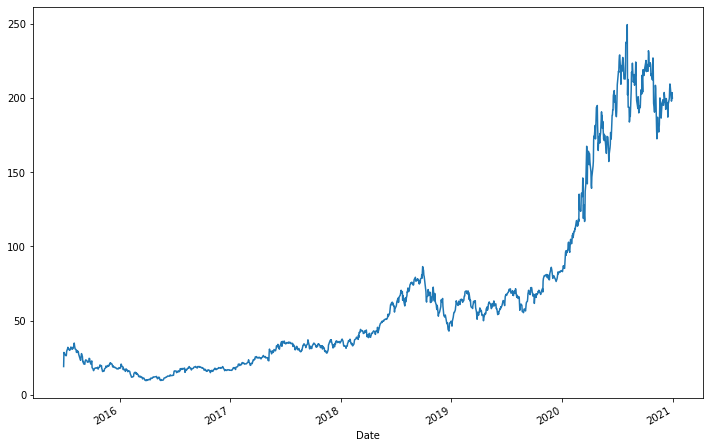

In [25]:
# plotting the Close column
master_df['Adj Close'].plot(figsize=(12,8))

#Feature Engineering

Creating the features and target columns, adding the lags and the performing feature reduction

[*********************100%***********************]  1 of 1 completed


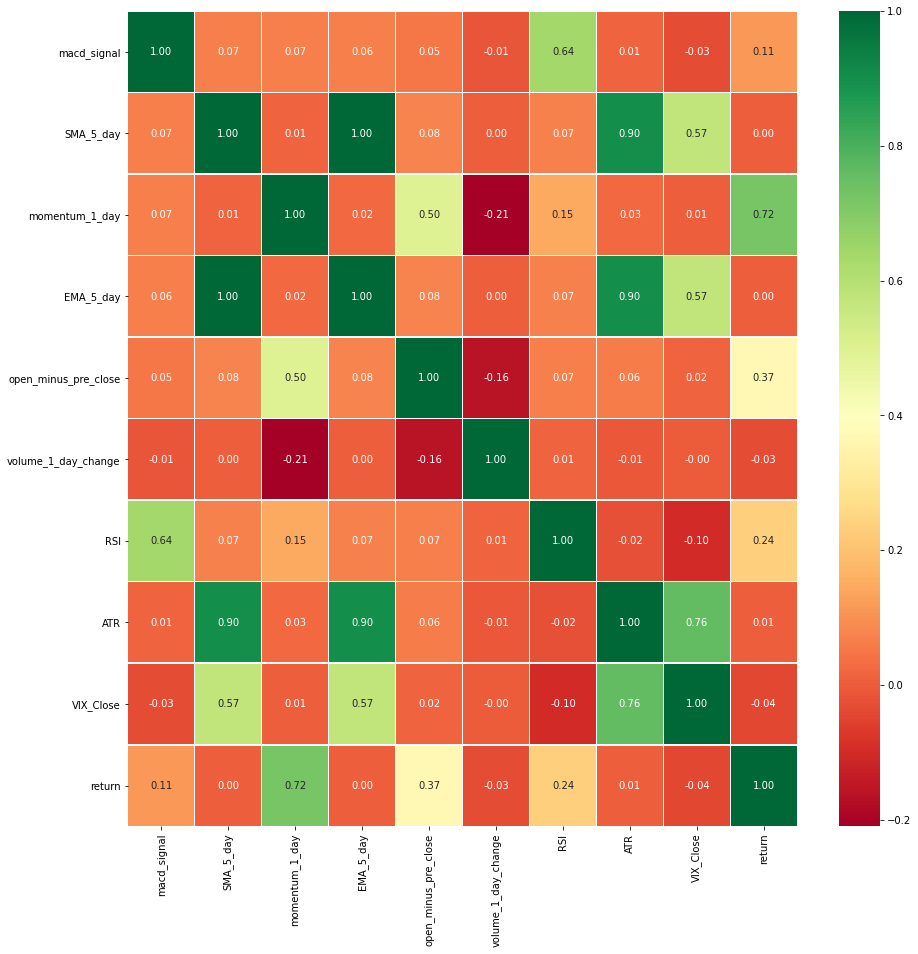

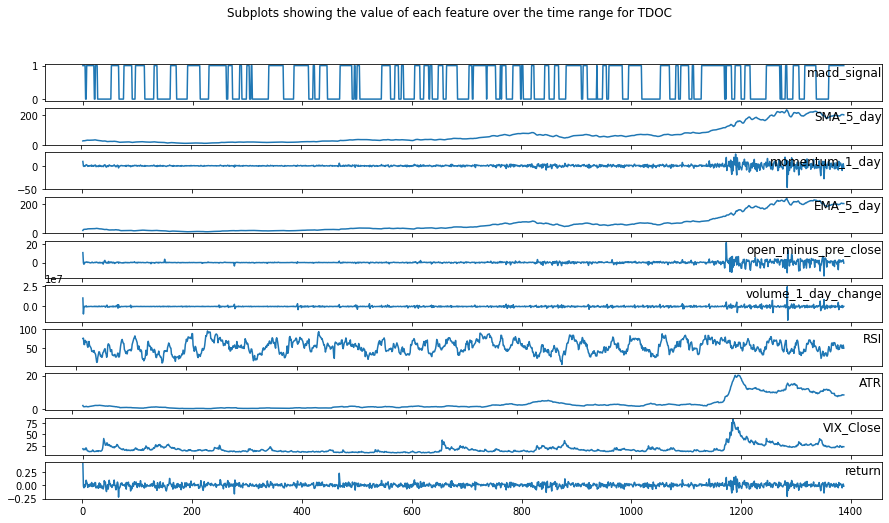

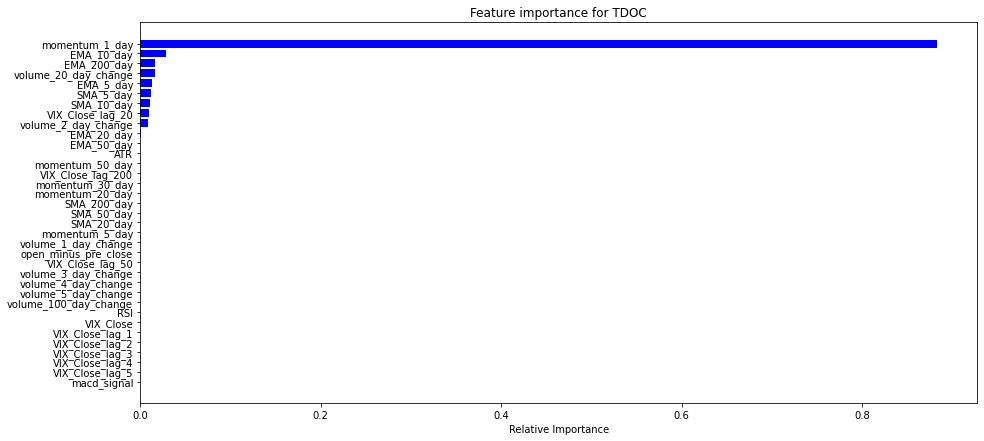

The percentage of class value: 0 is 55.33%
And the percentage of class value: 1 is 44.67%


 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 0.7151852455346749


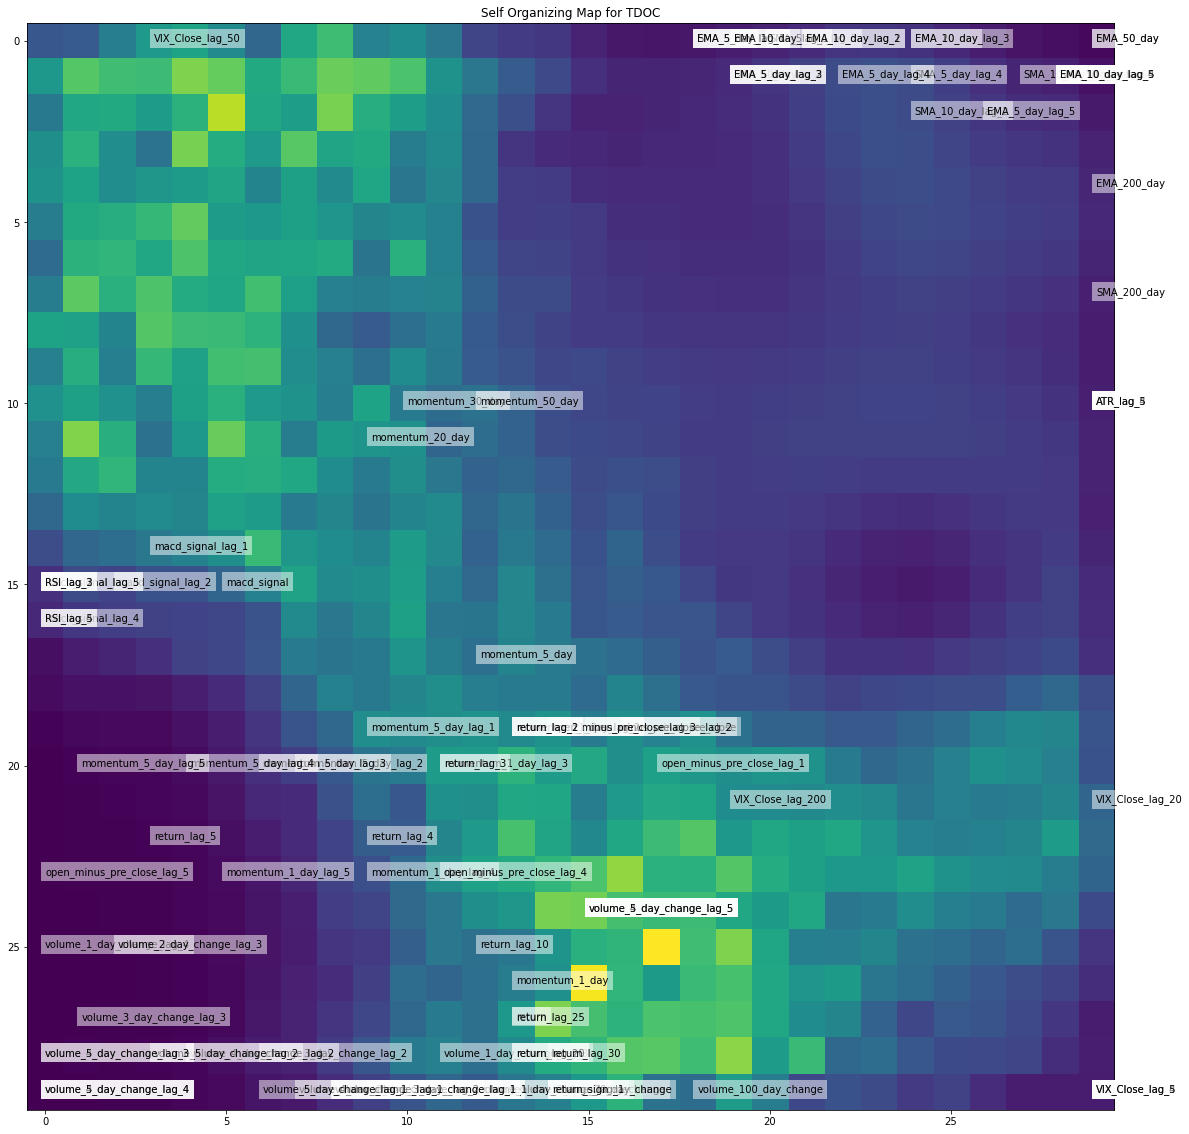

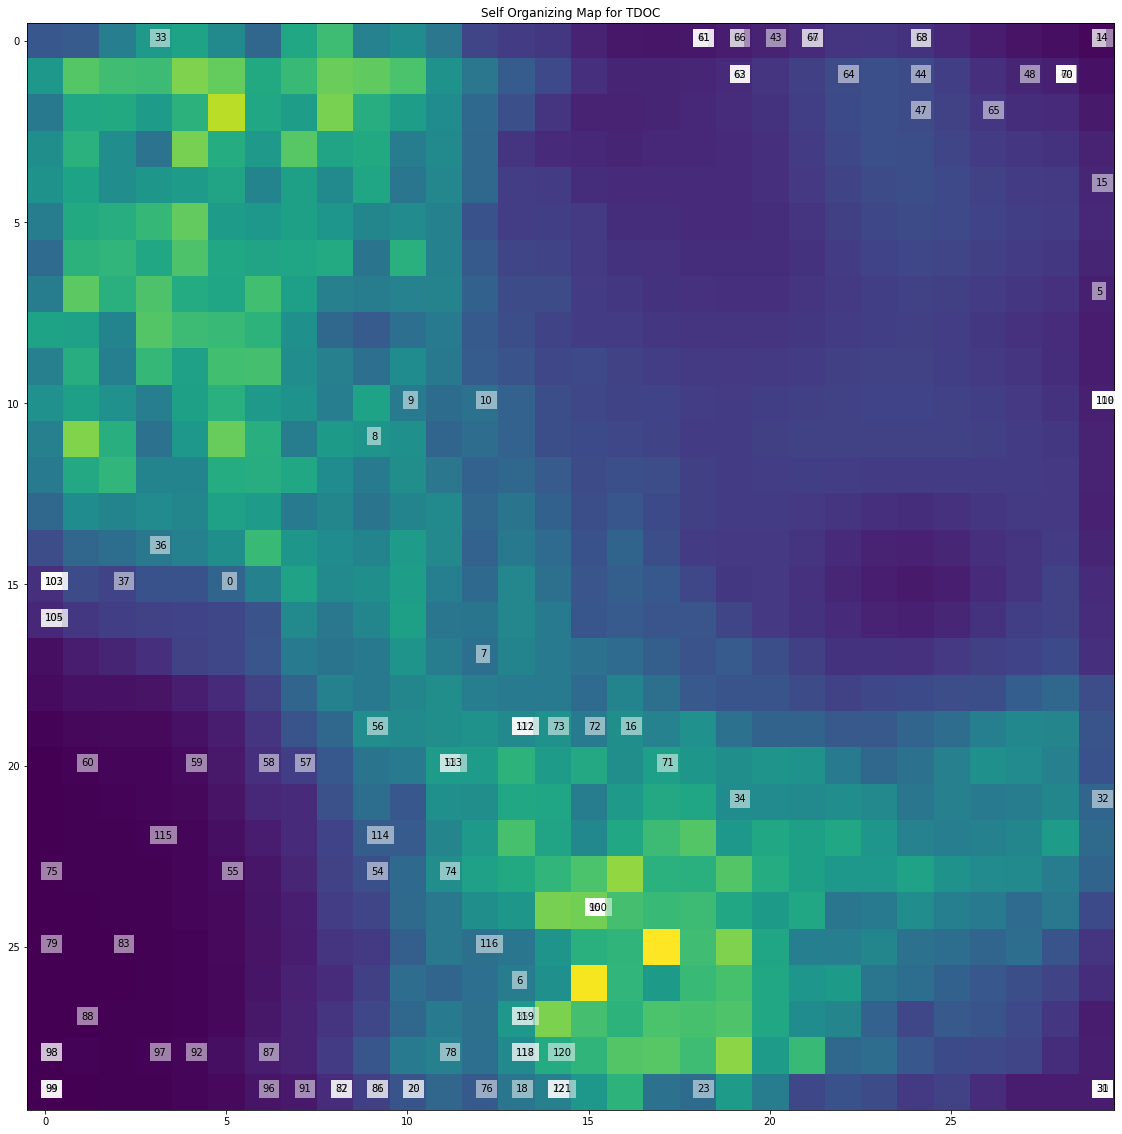

Key to the map
EMA_5_day_lag_2                62
EMA_5_day_lag_3                63
EMA_5_day_lag_4                64
EMA_5_day_lag_5                65
EMA_10_day_lag_1               66
EMA_10_day_lag_2               67
EMA_10_day_lag_3               68
EMA_10_day_lag_4               69
EMA_10_day_lag_5               70
open_minus_pre_close_lag_1     71
open_minus_pre_close_lag_2     72
open_minus_pre_close_lag_3     73
open_minus_pre_close_lag_4     74
open_minus_pre_close_lag_5     75
volume_1_day_change_lag_1      76
volume_1_day_change_lag_2      77
volume_1_day_change_lag_3      78
volume_1_day_change_lag_4      79
volume_1_day_change_lag_5      80
volume_2_day_change_lag_1      81
volume_2_day_change_lag_2      82
volume_2_day_change_lag_3      83
volume_2_day_change_lag_4      84
volume_2_day_change_lag_5      85
volume_3_day_change_lag_1      86
volume_3_day_change_lag_2      87
volume_3_day_change_lag_3      88
volume_3_day_change_lag_4      89
volume_3_day_change_lag_5      90

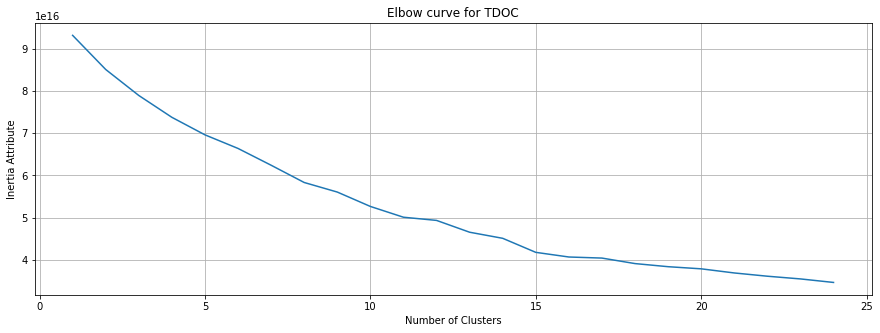

Now choose the number of clusters.
It is recommended we use a couple more clusters than the elbow test recommends.


In [26]:
# feature engineering
all_features_df = data_preparation(master_df, stock, show_feature_importance, start_date, end_date, 'decision_tree')

if SOM:
  corrmat_df = create_SOM_of_features(all_features_df, stock)
  # next remove the features which are similar in the correlation space.

  print('Key to the map')
  print(corrmat_df['number'].tail(60))

if k_means:
  # feature reductiong
  corrmat_df = first_run_of_k_means(all_features_df, stock)
  print('Now choose the number of clusters.\nIt is recommended we use a couple more clusters than the elbow test recommends.')

User selects number of clusters for k-means

In [27]:
if k_means:
  # choose the number of clusters
  n_clusters = 15
  second_run_of_k_means(corrmat_df, n_clusters)


Features assigned to cluster:  0
Index(['volume_2_day_change_lag_4', 'volume_3_day_change_lag_3',
       'volume_4_day_change_lag_2', 'volume_4_day_change_lag_3',
       'volume_5_day_change_lag_1', 'volume_5_day_change_lag_2',
       'volume_5_day_change_lag_3'],
      dtype='object')

Features assigned to cluster:  1
Index(['momentum_5_day', 'momentum_1_day_lag_3', 'momentum_5_day_lag_1',
       'momentum_5_day_lag_2', 'momentum_5_day_lag_3', 'return_lag_3'],
      dtype='object')

Features assigned to cluster:  2
Index(['momentum_1_day', 'open_minus_pre_close', 'return'], dtype='object')

Features assigned to cluster:  3
Index(['SMA_5_day', 'SMA_10_day', 'SMA_20_day', 'SMA_50_day', 'SMA_200_day',
       'EMA_5_day', 'EMA_10_day', 'EMA_20_day', 'EMA_50_day', 'EMA_200_day',
       'SMA_5_day_lag_1', 'SMA_5_day_lag_2', 'SMA_5_day_lag_3',
       'SMA_5_day_lag_4', 'SMA_5_day_lag_5', 'SMA_10_day_lag_1',
       'SMA_10_day_lag_2', 'SMA_10_day_lag_3', 'SMA_10_day_lag_4',
       'SMA_10_da

Select the finalised list the features post reduction

In [28]:
# The selected finalised list the features post reduction
df = all_features_df[['return' , 'return_lag_5', 'return_lag_10', 'return_lag_25', 'volume_1_day_change','volume_3_day_change_lag_2', 'volume_4_day_change_lag_2', 'volume_5_day_change_lag_5', 'volume_20_day_change', 'volume_100_day_change', 'momentum_1_day', 'momentum_5_day', 'momentum_5_day_lag_3', 'momentum_5_day_lag_5', 'macd_signal', 'macd_signal_lag_5','EMA_5_day', 'SMA_10_day','momentum_20_day', 'EMA_20_day','momentum_50_day', 'EMA_50_day', 'RSI', 'RSI_lag_1', 'EMA_200_day', 'ATR_lag_5', 'VIX_Close_lag_50', 'VIX_Close_lag_200', 'open_minus_pre_close', 'return_sign']]   

Printing the statistics of the base features

In [29]:
# finding the statistics of the base features
describe_df = df[['macd_signal', 'momentum_1_day', 'open_minus_pre_close', 'volume_1_day_change', 'RSI', 'return']].describe()
describe_df.head(10)

,macd_signal,momentum_1_day,open_minus_pre_close,volume_1_day_change,RSI,return
count,1173.000000,1173.000000,1173.000000,1.173000e+03,1173.000000,1173.000000
mean,0.532822,0.160929,0.097223,4.542967e+03,56.115965,0.002458
std,0.499134,3.901767,1.854923,1.330565e+06,15.257037,0.035586
min,0.000000,-47.410004,-14.764999,-1.704130e+07,7.951077,-0.210821
25%,0.000000,-0.750000,-0.150000,-3.058000e+05,44.653559,-0.016494
50%,1.000000,0.100006,0.049999,-1.330000e+04,56.254236,0.004117
75%,1.000000,1.150002,0.400000,2.776000e+05,68.168174,0.022122
max,1.000000,25.699997,22.039993,2.449990e+07,95.937496,0.224456


Adding more target value columns, if the user has selected greater than one to prediction into the future

In [30]:
# next check how many days into the future we want to predict
if num_days_to_predict > 1:
    # because the target is final feature date + 1, we want future lags up to num_days_to_predict-1
    df, target_cols, new_cols = add_future_output_for_train(df, 'return_sign', num_days_to_predict-1)
    # columns to drop from features
    # the target column is not automatically dropped from the feature dataframe
    # we have deicded to drop the return sign, as it is highly correlated with the return column
    # thus we will drop all target_cols, not just new_cols
    columns_drop = target_cols
    target_col = target_cols
else:
    columns_drop = ['return_sign']
    target_col = 'return_sign'

# drop  rows with NaNs in
df= df.dropna(axis=0)

# split test and train
train_df, test_df = split_test_and_train(df, test_length, verbose=None)
# split features and target from test and train
x_train, y_train, x_test, y_test = split_features_and_target(train_df, test_df, target_col, columns_drop=columns_drop) # where columns_drop is a list
# scale features
scaled_x_train, scaled_x_test = scale_features(x_train, x_test)

# I also want a validation dataset to help prevent overfitting
train_df_smaller, validation_df = split_test_and_train(train_df, test_length, verbose=None)
x_train_smaller, y_train_smaller, x_validate, y_validate = split_features_and_target(train_df_smaller, validation_df , target_col, columns_drop=columns_drop)
scaled_x_train_smaller, scaled_x_validate = scale_features(x_train_smaller, x_validate)

A list of all features used in the model

In [31]:
x_train.columns

Index(['return', 'return_lag_5', 'return_lag_10', 'return_lag_25',
       'volume_1_day_change', 'volume_3_day_change_lag_2',
       'volume_4_day_change_lag_2', 'volume_5_day_change_lag_5',
       'volume_20_day_change', 'volume_100_day_change', 'momentum_1_day',
       'momentum_5_day', 'momentum_5_day_lag_3', 'momentum_5_day_lag_5',
       'macd_signal', 'macd_signal_lag_5', 'EMA_5_day', 'SMA_10_day',
       'momentum_20_day', 'EMA_20_day', 'momentum_50_day', 'EMA_50_day', 'RSI',
       'RSI_lag_1', 'EMA_200_day', 'ATR_lag_5', 'VIX_Close_lag_50',
       'VIX_Close_lag_200', 'open_minus_pre_close'],
      dtype='object')

Setting the variables after reading in data

In [32]:
# Set the variables after reading in data
n_features = len(x_train.columns)
batch_size = 1
num_neurons_layer_1 = len(x_train.columns)# len(x_train)
if num_days_to_predict > 1:
    num_neurons_layer_2 = y_train.shape[1]
else:
    num_neurons_layer_2 = 1

Creating the three time series generators

In [33]:
# create the generator
generator_train = TimeseriesGenerator(scaled_x_train, y_train, length=length, batch_size=batch_size)
generator_train_smaller = TimeseriesGenerator(scaled_x_train_smaller, y_train_smaller, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_x_validate, y_validate, length=length, batch_size=batch_size)
test_generator = TimeseriesGenerator(scaled_x_test, y_test, length=length, batch_size=batch_size)

#Build, Compile and Train the Model

In [34]:
# build and compile the model
model_1 = create_rnn_model(num_neurons_layer_1, num_neurons_layer_2, 'sigmoid', 'sigmoid', (length, n_features), 'binary_crossentropy', 'Adam', num_layers = 5, layer_type = 'LSTM', dropout = None, metrics=metrics)

# fit the model
model_1.fit_generator(generator_train_smaller, validation_data=validation_generator, epochs=45, callbacks=[early_stop])
# print model summary
model_1.summary()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/45
543/543 [==============================] - 20s 30ms/step - loss: 0.6900 - accuracy: 0.5395 - AUC: 0.4511 - val_loss: 0.6909 - val_accuracy: 0.5370 - val_AUC: 0.5000
Epoch 2/45
543/543 [==============================] - 16s 29ms/step - loss: 0.6877 - accuracy: 0.5681 - AUC: 0.4509 - val_loss: 0.7001 - val_accuracy: 0.5370 - val_AUC: 0.5000
Epoch 3/45
543/543 [==============================] - 16s 29ms/step - loss: 0.6922 - accuracy: 0.5669 - AUC: 0.4377 - val_loss: 0.6904 - val_accuracy: 0.5370 - val_AUC: 0.5000
Epoch 4/45
543/543 [==============================] - 16s 29ms/step - loss: 0.6872 - accuracy: 0.5810 - AUC: 0.4285 - val_loss: 0.6904 - val_accuracy: 0.5370 - val_AUC: 0.5000
Epoch 5/45
543/543 [==============================] - 16s 29ms/step - loss: 0.6799 - accuracy: 0.5919 - AUC: 0.4710 - val_loss: 0.6922 - val_accuracy: 0.5370 - val_AUC: 0.5000
Epoch 6/45
543/543 [==============================] - 16s 29ms/step - loss: 0.6877 - accuracy: 0.5634 - AUC: 0.4253 - va

Text(0.5, 1.0, 'Model Stats for TDOC')

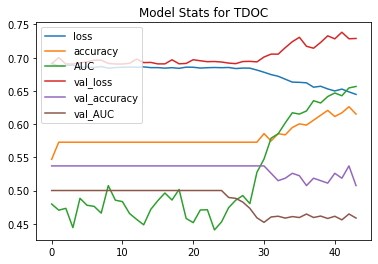

In [35]:
# plot the loss
loss_df = pd.DataFrame(model_1.history.history)
loss_df.plot()
plt.title('Model Stats for %s' % stock)

Re-train the model using the correct number of epochs

In [36]:
# re-fit model with correct number of epochs
# # build and compile the model
model_2 = create_rnn_model(num_neurons_layer_1, num_neurons_layer_2, 'sigmoid', 'sigmoid', (length, n_features), 'binary_crossentropy', 'Adam', num_layers = 3, layer_type = 'LSTM', dropout = None, metrics=metrics)
if stock == 'DIS':
    num_epochs = 30
elif stock == 'MELI':
      num_epochs = 32
elif stock == 'TDOC':
      num_epochs = 41

model_2.fit_generator(generator_train, epochs=num_epochs)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/41
843/843 [==============================] - 14s 14ms/step - loss: 0.6964 - accuracy: 0.5419 - AUC: 0.4719
Epoch 2/41
843/843 [==============================] - 11s 13ms/step - loss: 0.6935 - accuracy: 0.5421 - AUC: 0.4507
Epoch 3/41
843/843 [==============================] - 11s 13ms/step - loss: 0.6911 - accuracy: 0.5351 - AUC: 0.4739
Epoch 4/41
843/843 [==============================] - 11s 14ms/step - loss: 0.6838 - accuracy: 0.5742 - AUC: 0.4779
Epoch 5/41
843/843 [==============================] - 11s 13ms/step - loss: 0.6922 - accuracy: 0.5446 - AUC: 0.4422
Epoch 6/41
843/843 [==============================] - 11s 13ms/step - loss: 0.6893 - accuracy: 0.5566 - AUC: 0.4597
Epoch 7/41
843/843 [==============================] - 11s 13ms/step - loss: 0.6849 - accuracy: 0.5681 - AUC: 0.4659
Epoch 8/41
843/843 [==============================] - 11s 13ms/step - loss: 0.6835 - accuracy: 0.5746 - AUC: 0.4808
Epoch 9/41
843/843 [==============================] - 11s 13ms/step - lo

#Model predictions

Running the train dataset through the model and outputing the metrics

In [37]:
# now let's see if the training data is fitting the model well, before we run the test data through
if num_days_to_predict > 1:
    train_pred_class = np.where(model_2.predict(generator_train, batch_size=None) > 0.5, 1, 0)

    # currently we are just going to predict the final day, so we want the last value from each daily set of numbers.
    final_col_train_pred_class = train_pred_class[:, -1]
    final_col_y_train = y_train[:, -1]
else:
    final_col_train_pred_class = np.where(model_2.predict(generator_train, batch_size=None) > 0.5, 1, 0).flatten()
    final_col_y_train = y_train

start_train = final_col_y_train.shape[0] - len(final_col_train_pred_class)
reshaped_y_train = final_col_y_train[start_train: ]

# print the classification report for the test data set
print(classification_report(reshaped_y_train, final_col_train_pred_class)) 

              precision    recall  f1-score   support

         0.0       0.63      0.68      0.65       473
         1.0       0.54      0.48      0.51       370

    accuracy                           0.59       843
   macro avg       0.58      0.58      0.58       843
weighted avg       0.59      0.59      0.59       843



[[324 149]
 [194 176]]


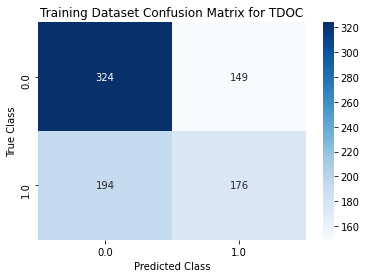

In [38]:
# confusion matrix
M_class_names_train = np.unique(y_train)
M_dt_cm = plot_confusion_matrix(reshaped_y_train, final_col_train_pred_class, M_class_names_train, str('Training Dataset Confusion Matrix for %s' % stock))

Running the test dataset through the model and outputing the metrics

In [39]:
# run test dataset through the model 
if num_days_to_predict > 1:
    test_pred_class = np.where(model_2.predict(test_generator, batch_size=None) > 0.50, 1, 0)
    # currently we are just going to predict the final day, so we want the last value from each daily set of numbers.
    final_col_test_pred_class = test_pred_class[:, -1]
    final_col_y_test = y_test[:, -1]
else:
    final_col_test_pred_class = np.where(model_2.predict(test_generator, batch_size=None) > 0.5, 1, 0).flatten()
    final_col_y_test = y_test

# print the classification report for the test data set
start_test = final_col_y_test.shape[0] - len(final_col_test_pred_class)
reshaped_y_test = final_col_y_test[start_test: ]
print(classification_report(reshaped_y_test, final_col_test_pred_class)) 

              precision    recall  f1-score   support

         0.0       0.41      0.08      0.14       142
         1.0       0.46      0.87      0.60       128

    accuracy                           0.46       270
   macro avg       0.44      0.48      0.37       270
weighted avg       0.44      0.46      0.36       270



[[ 12 130]
 [ 17 111]]


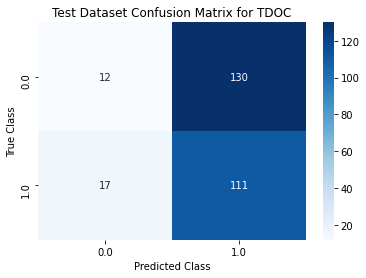

In [40]:
# confusion matrix
M_class_names = np.unique(y_test)
M_dt_cm = plot_confusion_matrix(reshaped_y_test, final_col_test_pred_class, M_class_names, str('Test Dataset Confusion Matrix for %s' % stock ))

# Backtesting

##Data preparation for backtesting

Finding the absolute predicted values for the train, test and validation dataset

In [41]:
# for backtesting we need the absolute values output by the model, not just 0 or 1
# absolute predicted value for test dataset
if num_days_to_predict > 1:
    test_prediction = model_2.predict(test_generator, batch_size=None)
    # currently we are just going to predict the final day, so we want the last value from each daily set of numbers.
    final_col_test_pred = test_prediction[:, -1]
    final_col_y_test = y_test[:, -1]
else:
    test_prediction = model_2.predict(test_generator, batch_size=None).flatten()
    final_col_test_pred = test_prediction

In [42]:
# next run the validation data through the model to get absolute predicted value
validation_prediction = model_2.predict(validation_generator, batch_size=None)
if num_days_to_predict > 1:
    validation_prediction = model_2.predict(validation_generator, batch_size=None)
    # currently we are just going to predict the final day, so we want the last value from each daily set of numbers.
    final_col_val_pred = validation_prediction[:, -1]
    final_col_y_val = y_validate[:, -1]
else:
    validation_prediction = model_2.predict(validation_generator, batch_size=None).flatten()
    final_col_val_pred = validation_prediction
    final_col_y_val = y_validate

# formating the true validation values
start_val = final_col_y_val.shape[0] - len(final_col_val_pred)
reshaped_y_val = final_col_y_val[start_val: ]

# next run the validation data through the model to get the 0 or 1 prediction
if num_days_to_predict > 1:
    val_pred_class = np.where(model_2.predict(validation_generator, batch_size=None) > 0.50, 1, 0)
    # currently we are just going to predict the final day, so we want the last value from each daily set of numbers.
    final_col_val_pred_class = val_pred_class[:, -1]
else:
    final_col_val_pred_class = np.where(model_2.predict(validation_generator, batch_size=None) > 0.5, 1, 0).flatten()

In [43]:
if num_days_to_predict > 1:
    train_pred = model_2.predict(generator_train, batch_size=None)
    # currently we are just going to predict the final day, so we want the last value from each daily set of numbers.
    final_col_train_pred = train_pred[:, -1]
else:
    final_col_train_pred = model_2.predict(generator_train, batch_size=None).flatten()
# create the dataframe to create the grahos below
train_true_predict_data = {'prediction': final_col_train_pred, 'true': reshaped_y_train}
train_true_predict_df = pd.DataFrame(data=train_true_predict_data, columns=['prediction', 'true'])



Calculating the optimum buy and sell thresholds

In [44]:
# finding the optimum sell split
sell_x_axis = []
sell_y_axis  = []
sell_y_axis_2 = []
for sell_num in range(50, 81, 1):
  # split the dataframe at the correct fraction
  pred_above_fraction = train_true_predict_df.loc[train_true_predict_df['prediction'] > sell_num/100.0]
  true_above_fraction = pred_above_fraction.loc[pred_above_fraction['true'] > 0]
  if len(true_above_fraction) > 0:
      sell_y_axis.append((len(true_above_fraction)/len(pred_above_fraction))*100.0)
  else:
      sell_y_axis.append(0)
  sell_x_axis.append(sell_num/100.0)
  sell_y_axis_2.append(len(true_above_fraction))

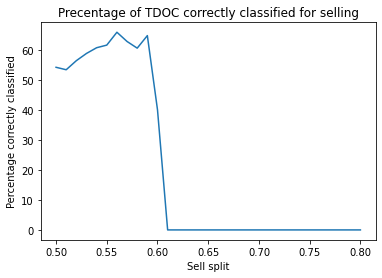

In [45]:
plt.figure()
plt.plot(sell_x_axis, sell_y_axis)
plt.ylabel('Percentage correctly classified')
plt.xlabel('Sell split')
plt.title('Precentage of %s correctly classified for selling' % stock)
plt.show()

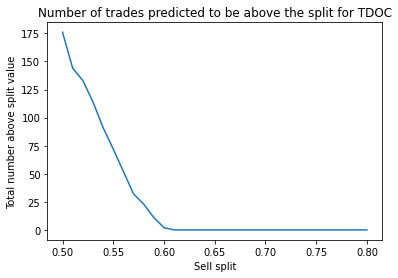

In [46]:
plt.figure()
plt.plot(sell_x_axis, sell_y_axis_2)
plt.ylabel('Total number above split value')
plt.xlabel('Sell split')
plt.title('Number of trades predicted to be above the split for %s' % stock)
plt.show()

In [47]:
# finding the optimum buy split
buy_x_axis = []
buy_y_axis  = []
buy_y_axis_2  = []
for buy_num in range(20, 51, 1):
  # split the dataframe at the correct fraction
  pred_below_fraction = train_true_predict_df.loc[train_true_predict_df['prediction'] < buy_num/100.0]
  true_below_fraction = pred_below_fraction.loc[pred_below_fraction['true'] < 1]
  if len(true_below_fraction) > 0:
      buy_y_axis.append((len(true_below_fraction)/len(pred_below_fraction))*100.0)
  else:
      buy_y_axis.append(0)
  buy_x_axis.append(buy_num/100.0)
  buy_y_axis_2.append(len(true_below_fraction))

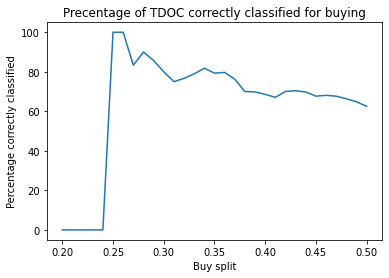

In [48]:
plt.figure()
plt.plot(buy_x_axis, buy_y_axis)
plt.ylabel('Percentage correctly classified')
plt.xlabel('Buy split')
plt.title('Precentage of %s correctly classified for buying' % stock)
plt.show()

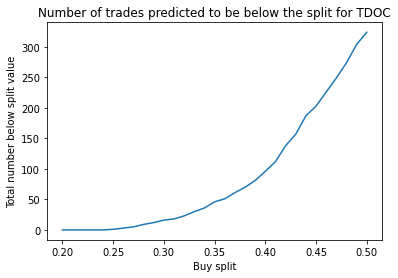

In [49]:
plt.figure()
plt.plot(buy_x_axis, buy_y_axis_2)
plt.ylabel('Total number below split value')
plt.xlabel('Buy split')
plt.title('Number of trades predicted to be below the split for %s' % stock)
plt.show()

Setting the user defined variables for backtesting

In [50]:
# set the user defined variables for backtesting
initial_investment = 0.75 # fraction
total_in_bank = 1000
max_buy_and_sell = 1 # fraction
if stock == 'DIS':
  buy_threshold = 0.42
  sell_threshold = 0.57
elif stock == 'MELI':
  buy_threshold = 0.48
  sell_threshold = 0.53
elif stock == 'TDOC':
  buy_threshold = 0.4
  sell_threshold = 0.57
else:
  buy_threshold = 0.5
  sell_threshold = 0.5

##Backtesting functions

Function to preform the backtesting of the test dataset

In [51]:
# function to perform backtesting of test dataset
def backtesting_test_dataset(backtest_df, total_in_bank, 
    num_positive_trades, money_made_positive_trades, num_negative_trades,
    money_lost_negative_trades, num_of_trades, max_buy_and_sell, buy_threshold, 
    sell_threshold):
    # initialise money in the bank at the start of the day
    start_day_money = total_in_bank
    # reset EOD_running_total
    EOD_running_total = []

    for num in range(0, len(backtest_df)):
        if backtest_df['predicted'].iloc[num] < buy_threshold:
            # buy
            # amount to buy calculate Kelly criteria to calculate how much to buy
            kelly_fraction = (num_positive_trades/num_of_trades) - ((1-(num_positive_trades/num_of_trades))/((money_made_positive_trades/num_positive_trades)/(money_lost_negative_trades/num_negative_trades)))
            # next check that the kelly_fraction is <= to max_buy_and_sell
            if kelly_fraction > max_buy_and_sell:
              kelly_fraction = max_buy_and_sell

            buy_amount = start_day_money * kelly_fraction
            amount_left_in_bank = start_day_money - buy_amount
            # end of day stock 
            EOD_stock = buy_amount + (buy_amount * backtest_df['buy_return'].iloc[num])
            # add this bank into the bank
            start_day_money = amount_left_in_bank + EOD_stock
            # append EOD_running_total
            EOD_running_total.append(start_day_money)
            # add one to number of trades
            num_of_trades += 1
            # next see if increase or decrease
            if backtest_df['C-O'].iloc[num] >= 0:
                # add one to positive trades
                num_positive_trades += 1
                money_made_positive_trades += buy_amount * backtest_df['buy_return'].iloc[num]
            else:
                # add one to negative trades
                num_negative_trades += 1
                money_lost_negative_trades += abs(buy_amount * backtest_df['buy_return'].iloc[num])

        elif backtest_df['predicted'].iloc[num] > sell_threshold:
            # sell
            # amount to sell calculate Kelly criteria to calculate how much to buy
            kelly_fraction = (num_positive_trades/num_of_trades) - ((1-(num_positive_trades/num_of_trades))/((money_made_positive_trades/num_positive_trades)/(money_lost_negative_trades/num_negative_trades)))
            # next check that the kelly_fraction is <= to max_buy_and_sell
            if kelly_fraction > max_buy_and_sell:
                kelly_fraction = max_buy_and_sell

            sell_amount = start_day_money * kelly_fraction
            amount_left_in_bank = start_day_money - sell_amount
            # end of day stock
            EOD_stock = sell_amount + (sell_amount * backtest_df['sell_return'].iloc[num])
            # add this bank into the bank
            start_day_money = amount_left_in_bank + EOD_stock
            # append EOD_running_total
            EOD_running_total.append(start_day_money)
            # add one to number of trades
            num_of_trades += 1
            # next see if increase or decrease
            if backtest_df['C-O'].iloc[num] <= 0:
                # add one to positive trades
                num_positive_trades += 1
                money_made_positive_trades += sell_amount * backtest_df['sell_return'].iloc[num]
            else:
                # add one to negative trades
                num_negative_trades += 1
                money_lost_negative_trades += abs(sell_amount * backtest_df['sell_return'].iloc[num])
        else:
            # no trade
            EOD_running_total.append(start_day_money)

    backtest_df['EOD_running_total'] = EOD_running_total
    return backtest_df

Function to initialise Kelly criterion using the validation dataset

In [52]:
# function to initialise kelly criterion
def initialise_kelly_criterion(backtest_df, total_in_bank, 
    num_positive_trades, money_made_positive_trades, num_negative_trades,
    money_lost_negative_trades, num_of_trades, max_buy_and_sell, buy_threshold, 
    sell_threshold, EOD_running_total):
    start_day_money = total_in_bank

    for num in range(0, len(backtest_df)):
        # using the initial value for half of the trades
        if num < (len(backtest_df)/2):
            # buy or sell
            if backtest_df['predicted'].iloc[num] < buy_threshold:
                # buy
                # amount to buy 
                buy_amount = start_day_money * initial_investment
                amount_left_in_bank = start_day_money - buy_amount
                # end of day stock 
                EOD_stock = buy_amount + (buy_amount * backtest_df['buy_return'].iloc[num])
                # add this bank into the bank
                start_day_money = amount_left_in_bank + EOD_stock
                # append EOD_running_total
                EOD_running_total.append(start_day_money)
                # add one to number of trades
                num_of_trades += 1
                # next see if increase or decrease
                if backtest_df['C-O'].iloc[num] >= 0:
                    # add one to positive trades
                    num_positive_trades += 1
                    money_made_positive_trades += buy_amount * backtest_df['buy_return'].iloc[num]
                else:
                    # add one to negative trades
                    num_negative_trades += 1
                    money_lost_negative_trades += abs(buy_amount * backtest_df['buy_return'].iloc[num])
            elif backtest_df['predicted'].iloc[num] > sell_threshold:
                # sell
                # sell amount
                sell_amount = start_day_money * initial_investment
                amount_left_in_bank = start_day_money - sell_amount
                # end of day stock
                EOD_stock = sell_amount + (sell_amount * backtest_df['sell_return'].iloc[num])
                # add this bank into the bank
                start_day_money = amount_left_in_bank + EOD_stock
                # append EOD_running_total
                EOD_running_total.append(start_day_money)
                # add one to number of trades
                num_of_trades += 1
                # next see if increase or decrease
                if backtest_df['C-O'].iloc[num] <= 0:
                    # add one to positive trades
                    num_positive_trades += 1
                    money_made_positive_trades += sell_amount * backtest_df['sell_return'].iloc[num]
                else:
                    # add one to negative trades
                    num_negative_trades += 1
                    money_lost_negative_trades += abs(sell_amount * backtest_df['sell_return'].iloc[num])
            else:
                  # no trade
                  EOD_running_total.append(start_day_money)
        
        # subsequent trades
        else:
            # buy or sell
            if backtest_df['predicted'].iloc[num] < buy_threshold:
                # buy
                # amount to buy 
                # calculate Kelly criteria to calculate how much to buy
                kelly_fraction = (num_positive_trades/num_of_trades) - ((1-(num_positive_trades/num_of_trades))/((money_made_positive_trades/num_positive_trades)/(money_lost_negative_trades/num_negative_trades)))
                # next check that the kelly_fraction is <= to max_buy_and_sell
                if kelly_fraction > max_buy_and_sell:
                  kelly_fraction = max_buy_and_sell

                buy_amount = start_day_money * kelly_fraction
                amount_left_in_bank = start_day_money - buy_amount
                # end of day stock 
                EOD_stock = buy_amount + (buy_amount * backtest_df['buy_return'].iloc[num])
                # add this bank into the bank
                start_day_money = amount_left_in_bank + EOD_stock
                # append EOD_running_total
                EOD_running_total.append(start_day_money)
                # add one to number of trades
                num_of_trades += 1
                # next see if increase or decrease
                if backtest_df['C-O'].iloc[num] >= 0:
                    # add one to positive trades
                    num_positive_trades += 1
                    money_made_positive_trades += buy_amount * backtest_df['buy_return'].iloc[num]
                else:
                    # add one to negative trades
                    num_negative_trades += 1
                    money_lost_negative_trades += abs(buy_amount * backtest_df['buy_return'].iloc[num])
            elif backtest_df['predicted'].iloc[num] > sell_threshold:
                # sell
                # calculate Kelly criteria to calculate how much to buy
                kelly_fraction = (num_positive_trades/num_of_trades) - ((1-(num_positive_trades/num_of_trades))/((money_made_positive_trades/num_positive_trades)/(money_lost_negative_trades/num_negative_trades)))
                # next check that the kelly_fraction is <= to max_buy_and_sell
                if kelly_fraction > max_buy_and_sell:
                  kelly_fraction = max_buy_and_sell

                sell_amount = start_day_money * kelly_fraction
                amount_left_in_bank = start_day_money - sell_amount
                # end of day stock
                EOD_stock = sell_amount + (sell_amount * backtest_df['sell_return'].iloc[num])
                # add this bank into the bank
                start_day_money = amount_left_in_bank + EOD_stock
                # append EOD_running_total
                EOD_running_total.append(start_day_money)
                # add one to number of trades
                num_of_trades += 1
                # next see if increase or decrease
                if backtest_df['C-O'].iloc[num] <= 0:
                    # add one to positive trades
                    num_positive_trades += 1
                    money_made_positive_trades += sell_amount * backtest_df['sell_return'].iloc[num]
                else:
                    # add one to negative trades
                    num_negative_trades += 1
                    money_lost_negative_trades += abs(sell_amount * backtest_df['sell_return'].iloc[num])
            else:
                # no trade
                EOD_running_total.append(start_day_money)

    backtest_df['EOD_running_total'] = EOD_running_total
    return num_positive_trades, money_made_positive_trades, num_negative_trades,money_lost_negative_trades, num_of_trades, backtest_df

Function to format the true and predicted values in preperation for backtesting

In [53]:
def create_df_for_backtesting(master_df, x_test, final_col_test_pred, start_test, reshaped_y_test, final_col_test_pred_class):
  # first we need the dates for the predicted test data results
  # to get these, let's remove the first start_test-1 from x_test to get the index
  # but remember x_test has the information about the next day, not the current day 
  # so we want to remove start_test from x_test
  smaller_x_test = x_test.iloc[start_test:]
  # now let's create the dataframe to hold the information in 
  backtest_df = pd.DataFrame(index=smaller_x_test.index)
  backtest_df['Open'] = master_df['Open']
  backtest_df['Close'] = master_df['Close']
  # we need to remove the final value from final_col_test_pred
  shorter_final_col_test_pred = final_col_test_pred[:]
  backtest_df['predicted_class'] = final_col_test_pred_class.tolist()
  backtest_df['predicted'] = shorter_final_col_test_pred.tolist()
  backtest_df['true_signal'] = reshaped_y_test[:].tolist()
  backtest_df['C-O'] = backtest_df['Close'] - backtest_df['Open']
  backtest_df['buy_return'] = (backtest_df['Close']/backtest_df['Open'])-1
  backtest_df['sell_return'] = (backtest_df['Open']/backtest_df['Close'])-1 
  backtest_df['percent_decrease'] = (backtest_df['Open'] - backtest_df['Close'])/backtest_df['Open'] # edit
  return backtest_df

Function to call initialising the Kelly criterion and the backtesting code

In [54]:
# backtesting function
def backtesting(master_df, x_test, final_col_test_pred, x_validate, 
                final_col_val_pred, start_test, initial_investment, 
                total_in_bank, max_buy_and_sell, buy_threshold, sell_threshold, 
                reshaped_y_test, final_col_test_pred_class, final_col_val_pred_class):
    # initialising variables for backtesting
    EOD_running_total = []
    num_positive_trades = 0
    money_made_positive_trades = 0
    num_negative_trades = 0
    money_lost_negative_trades = 0
    num_of_trades = 0
    
    # first create the validation backtesting dataframe to initialise the kelly criteria
    validation_backtest_df = create_df_for_backtesting(master_df, x_validate, 
                            final_col_val_pred, start_test, reshaped_y_val, final_col_val_pred_class)
    # next create the test dataset 
    backtest_df = create_df_for_backtesting(master_df, x_test, 
                            final_col_test_pred, start_test, reshaped_y_test, final_col_test_pred_class)
    
    # next run the validation_backtest_df through initialiser
    num_positive_trades, money_made_positive_trades, \
    num_negative_trades, money_lost_negative_trades, \
    num_of_trades, temp_df = initialise_kelly_criterion(validation_backtest_df, total_in_bank, \
    num_positive_trades, money_made_positive_trades, num_negative_trades,\
    money_lost_negative_trades, num_of_trades, max_buy_and_sell, buy_threshold, \
    sell_threshold, EOD_running_total)

    # then run backtest_df through the backtesting model
    backtest_df = backtesting_test_dataset(backtest_df, total_in_bank, 
      num_positive_trades, money_made_positive_trades, num_negative_trades,
      money_lost_negative_trades, num_of_trades, max_buy_and_sell, 
      buy_threshold, sell_threshold)

    return backtest_df

##Running the backtesting code

In [55]:
backtest_df = backtesting(master_df, x_test, final_col_test_pred, x_validate, 
            final_col_val_pred, start_test, initial_investment, total_in_bank, 
            max_buy_and_sell, buy_threshold, sell_threshold, reshaped_y_test,
            final_col_test_pred_class, final_col_val_pred_class)



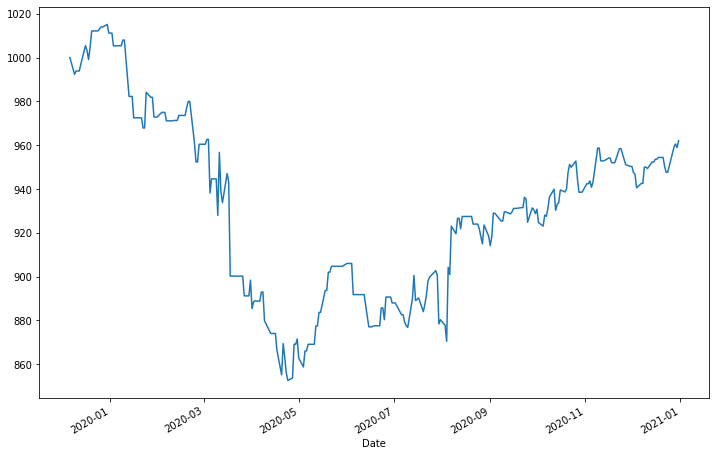

In [56]:
# plot the stock price move
backtest_df['EOD_running_total'].plot(figsize=(12,8))

##Plotting the tear sheet for the backtested code

Start date,2019-12-09
End date,2020-12-31
Total months,12
,Backtest
Annual return,-4.3%
Cumulative returns,-4.5%
Annual volatility,12.0%
Sharpe ratio,-0.30
Calmar ratio,-0.26
Stability,0.06
Max drawdown,-16.4%


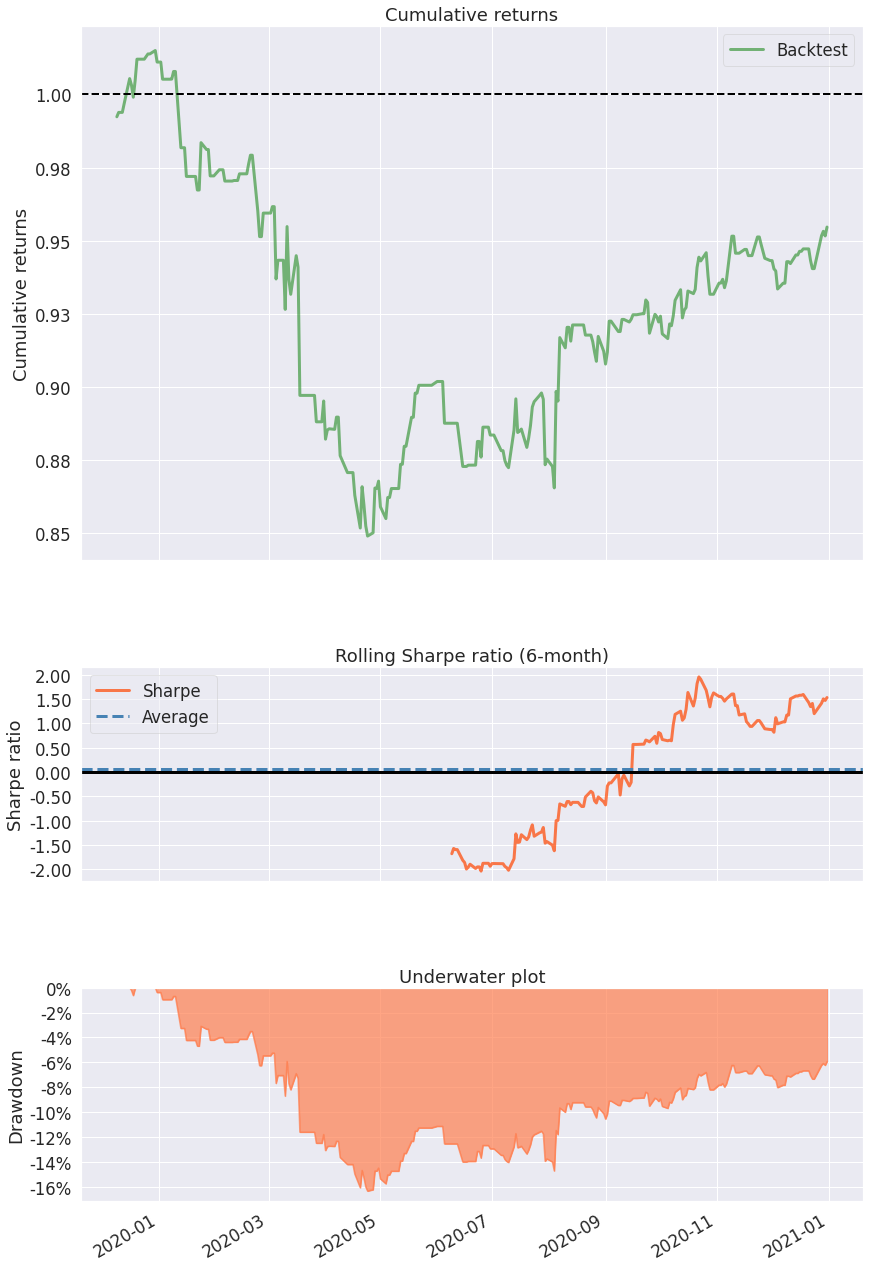

In [57]:
# next find the pyfolio stats
# we need to calculate the log returns of our investment
# treating our EOD_running_total as our close price

backtest_df['return'] = np.log(backtest_df['EOD_running_total'] / backtest_df['EOD_running_total'].shift(1))
# delete rows with nan in them
backtest_df = backtest_df.dropna(axis=0)
# next create the tear sheet for the returns on our investment
pf.create_simple_tear_sheet(backtest_df['return'])

# Comparing pre, peak and post Covid recovery

Function to take a date range, and df and print out the classification report and confusion matrix for that time period

In [58]:
# function to take a date range, and df and print out the classification report and confusion matrix for that time period
def accuracy_for_given_date_range(df, covid_start_date, covid_end_date, period, stock):
    # select date range
    smaller_df = df.iloc[(df.index >= covid_start_date) & (df.index < covid_end_date)]
    # print the classification report for the time range
    print('Classification report for %s' % period)
    print(classification_report(smaller_df['true_signal'], smaller_df['predicted_class'])) 
    # confusion matrix for the time range
    M_class_names = np.unique(smaller_df['true_signal'])
    M_dt_cm = plot_confusion_matrix(smaller_df['true_signal'], smaller_df['predicted_class'], M_class_names, str('Test Dataset Confusion Matrix for %s during %s' % (stock, period)))

Defining the start and end dates for pre-covid, peak-covid and post-covid recovery

In [59]:
pre_covid_start = '2019-12-01'
pre_covid_end = '2020-02-20'
peak_covid_start = '2020-02-21'
peak_covid_end = '2020-09-01'
post_covid_recovery_start = '2020-09-02'
post_covid_recovery_end = '2021-01-01'

Plotting the metrics for the pre-covid, peak-covid and post-covid recovery periods

Classification report for pre covid
              precision    recall  f1-score   support

         0.0       0.43      0.23      0.30        26
         1.0       0.43      0.65      0.52        23

    accuracy                           0.43        49
   macro avg       0.43      0.44      0.41        49
weighted avg       0.43      0.43      0.40        49

[[ 6 20]
 [ 8 15]]


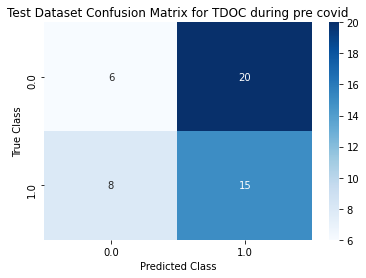

Classification report for peak covid
              precision    recall  f1-score   support

         0.0       0.38      0.07      0.12        72
         1.0       0.45      0.87      0.59        62

    accuracy                           0.44       134
   macro avg       0.42      0.47      0.35       134
weighted avg       0.41      0.44      0.34       134

[[ 5 67]
 [ 8 54]]


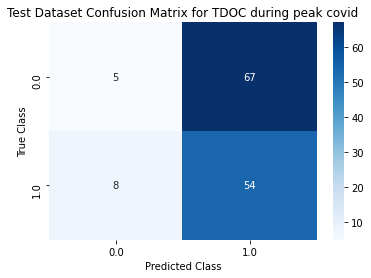

Classification report for post covid recovery
              precision    recall  f1-score   support

         0.0       0.50      0.02      0.05        42
         1.0       0.50      0.98      0.66        42

    accuracy                           0.50        84
   macro avg       0.50      0.50      0.35        84
weighted avg       0.50      0.50      0.35        84

[[ 1 41]
 [ 1 41]]


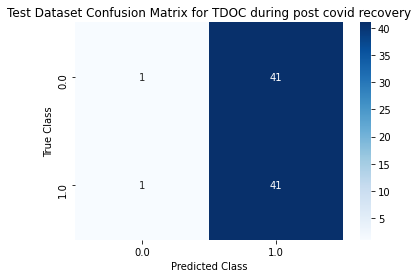

In [60]:
# accuracy for pre covid
accuracy_for_given_date_range(backtest_df, pre_covid_start, pre_covid_end, 'pre covid', stock)
# accuracy for peak covid
accuracy_for_given_date_range(backtest_df, peak_covid_start, peak_covid_end, 'peak covid', stock)
# accuracy post covid recovery
accuracy_for_given_date_range(backtest_df, post_covid_recovery_start, post_covid_recovery_end, 'post covid recovery', stock)